In [ ]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

from timm.data import Mixup
from timm.data.random_erasing import RandomErasing as RandomErasingTimm
from timm.loss import SoftTargetCrossEntropy
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d
from timm.models.layers.blur_pool import BlurPool2d

In [ ]:
%env WANDB_SILENT=true
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

In [ ]:
VERSION  = "NB_EXP_022"
EXP_NAME = f"{VERSION}_efficientnetv2_s"
MODEL_FOLDER = Path(f'/runs/{VERSION}'); os.makedirs(MODEL_FOLDER, exist_ok=True)

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

TIMM_MODEL = "tf_efficientnetv2_s_in21ft1k"

NFOLDS = 5; BS = 32; SZ = 256

In [4]:
all_df = pd.read_csv(CSV_PATH)

folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


In [5]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [6]:
def get_dls(fold:int, *args, **kwargs):
    
    item_tfms = [ToTensor, Resize(448, method=ResizeMethod.Squish)]
    aug_tfm = aug_transforms(flip_vert=True, 
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.5, 
                             pad_mode=PadMode.Zeros,
                             size=SZ,
                             xtra_tfms=RandomErasing(p=0.74))
    
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=BS)
    return dls

def build_experiment(fold:int = 0, pretrained:bool=True):
    print(f'model:{TIMM_MODEL}; pretrained:{pretrained}')
    print(f'fold:{fold}; sz:{SZ}; bs:{BS}')
    
    dls = get_dls(fold)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                           loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
    return dls, learn

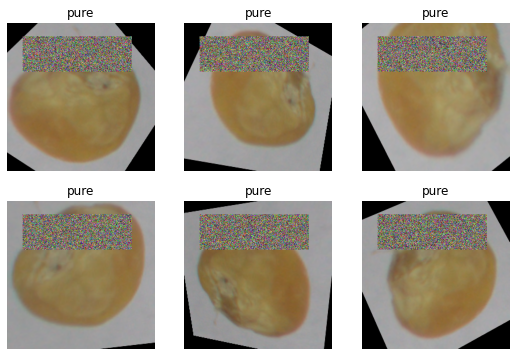

In [7]:
dls = get_dls(0)
dls.show_batch(unique=True, max_n=6)

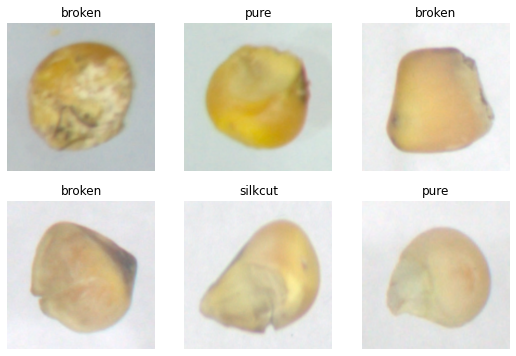

In [8]:
dls.valid.show_batch(max_n=6)

In [ ]:
# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):      
#     dls, learn = build_experiment(0)
#     print(learn.lr_find(suggest_funcs=(valley, slide)))

In [11]:
n_epo = 15; base_lr = 0.01;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup"

In [12]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True): 
        print()
        print('*' * 100)
        print(f'Training fold {fold_idx}')
        print('*' * 100)
        
        dls, learn = build_experiment(fold_idx)
        print(f'epochs:{n_epo}; base_lr:{base_lr}')
            
        cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater), MixUp(0.4)]
        
        learn.fine_tune(n_epo, base_lr, cbs=cbs)

        learn = learn.load("model")
        learn = learn.to_fp32()

        dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
        learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
model:tf_efficientnetv2_s_in21ft1k; pretrained:True
fold:0; sz:256; bs:32
epochs:15; base_lr:0.01


epoch,train_loss,valid_loss,accuracy,time
0,1.382564,1.088032,0.558464,00:47


Better model found at epoch 0 with accuracy value: 0.5584642291069031.


epoch,train_loss,valid_loss,accuracy,time
0,1.062472,0.937414,0.591623,01:05
1,1.029527,0.774009,0.694590,01:06
2,0.990751,0.692047,0.732286,01:05
3,0.940322,0.649533,0.747993,01:06
4,0.866523,0.623644,0.752531,01:06
5,0.864203,0.580686,0.777661,01:06
6,0.792030,0.562695,0.781850,01:06
7,0.787400,0.539307,0.788831,01:06
8,0.800724,0.530545,0.781850,01:06
9,0.768931,0.521312,0.796859,01:06


Better model found at epoch 0 with accuracy value: 0.5916230082511902.
Better model found at epoch 1 with accuracy value: 0.6945898532867432.
Better model found at epoch 2 with accuracy value: 0.7322862148284912.
Better model found at epoch 3 with accuracy value: 0.747992992401123.
Better model found at epoch 4 with accuracy value: 0.7525305151939392.
Better model found at epoch 5 with accuracy value: 0.7776614427566528.
Better model found at epoch 6 with accuracy value: 0.7818499207496643.
Better model found at epoch 7 with accuracy value: 0.7888306975364685.
Better model found at epoch 9 with accuracy value: 0.7968586683273315.
CPU: 144/18/3913 MB | GPU: 908/1678/4374 MB | Time 0:17:24.432 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 1
**************************************************

epoch,train_loss,valid_loss,accuracy,time
0,1.386371,1.240214,0.523211,00:48


Better model found at epoch 0 with accuracy value: 0.5232111811637878.


epoch,train_loss,valid_loss,accuracy,time
0,1.053353,0.946119,0.592670,01:06
1,0.998748,0.757985,0.689354,01:07
2,0.982776,0.663803,0.728796,01:06
3,0.897422,0.604417,0.759511,01:06
4,0.872853,0.604587,0.754625,01:07
5,0.826379,0.564537,0.773822,01:06
6,0.838993,0.569884,0.775218,01:07
7,0.804698,0.537989,0.786038,01:07
8,0.800248,0.530004,0.787086,01:06
9,0.800509,0.516745,0.800349,01:07


Better model found at epoch 0 with accuracy value: 0.5926701426506042.
Better model found at epoch 1 with accuracy value: 0.6893543004989624.
Better model found at epoch 2 with accuracy value: 0.7287958264350891.
Better model found at epoch 3 with accuracy value: 0.7595113515853882.
Better model found at epoch 5 with accuracy value: 0.773822009563446.
Better model found at epoch 6 with accuracy value: 0.77521812915802.
Better model found at epoch 7 with accuracy value: 0.7860383987426758.
Better model found at epoch 8 with accuracy value: 0.7870855331420898.
Better model found at epoch 9 with accuracy value: 0.8003490567207336.
Better model found at epoch 11 with accuracy value: 0.8041884899139404.
CPU: 16/18/3930 MB | GPU: 54/1958/4428 MB | Time 0:17:36.836 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


***************************************************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,1.372022,1.187816,0.534916,00:49


Better model found at epoch 0 with accuracy value: 0.5349162220954895.


epoch,train_loss,valid_loss,accuracy,time
0,1.037264,0.859989,0.649791,01:07
1,1.016300,0.814215,0.671089,01:07
2,0.964736,0.709156,0.720670,01:08
3,0.913778,0.668110,0.726257,01:07
4,0.871693,0.617750,0.753841,01:06
5,0.835145,0.584162,0.771299,01:07
6,0.805368,0.617268,0.754539,01:06
7,0.808811,0.551177,0.779330,01:07
8,0.788427,0.544836,0.788059,01:06
9,0.769643,0.529570,0.796439,01:06


Better model found at epoch 0 with accuracy value: 0.6497905254364014.
Better model found at epoch 1 with accuracy value: 0.6710894107818604.
Better model found at epoch 2 with accuracy value: 0.7206704020500183.
Better model found at epoch 3 with accuracy value: 0.7262569665908813.
Better model found at epoch 4 with accuracy value: 0.7538408041000366.
Better model found at epoch 5 with accuracy value: 0.771298885345459.
Better model found at epoch 7 with accuracy value: 0.7793295979499817.
Better model found at epoch 8 with accuracy value: 0.7880586385726929.
Better model found at epoch 9 with accuracy value: 0.7964385747909546.
CPU: 5/19/3935 MB | GPU: -40/1976/4388 MB | Time 0:17:34.913 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 3
****************************************************

epoch,train_loss,valid_loss,accuracy,time
0,1.407683,1.631024,0.309707,00:47


Better model found at epoch 0 with accuracy value: 0.3097067177295685.


epoch,train_loss,valid_loss,accuracy,time
0,1.038754,0.834939,0.670042,01:06
1,1.011796,0.764363,0.700768,01:06
2,0.969426,0.716964,0.702514,01:06
3,0.923882,0.593213,0.775489,01:06
4,0.889982,0.583809,0.781075,01:06
5,0.846232,0.580526,0.780028,01:06
6,0.829032,0.532266,0.789804,01:06
7,0.818369,0.509267,0.796788,01:06
8,0.787735,0.497358,0.806913,01:06
9,0.778123,0.499080,0.796439,01:06


Better model found at epoch 0 with accuracy value: 0.6700419187545776.
Better model found at epoch 1 with accuracy value: 0.7007681727409363.
Better model found at epoch 2 with accuracy value: 0.7025139927864075.
Better model found at epoch 3 with accuracy value: 0.7754888534545898.
Better model found at epoch 4 with accuracy value: 0.7810754179954529.
Better model found at epoch 6 with accuracy value: 0.7898044586181641.
Better model found at epoch 7 with accuracy value: 0.7967877388000488.
Better model found at epoch 8 with accuracy value: 0.806913435459137.
Better model found at epoch 10 with accuracy value: 0.8079608678817749.
Better model found at epoch 12 with accuracy value: 0.8163408041000366.
CPU: 3/18/3939 MB | GPU: 116/1898/4504 MB | Time 0:17:30.717 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


************************************************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,1.372467,1.078282,0.561103,00:48


Better model found at epoch 0 with accuracy value: 0.561103343963623.


epoch,train_loss,valid_loss,accuracy,time
0,1.075945,0.876587,0.660964,01:07
1,0.992787,0.850951,0.641760,01:06
2,0.990884,0.728474,0.714385,01:07
3,0.908067,0.615249,0.767807,01:06
4,0.881330,0.597692,0.766411,01:06
5,0.866273,0.580329,0.777235,01:06
6,0.828081,0.558431,0.780726,01:06
7,0.822037,0.556206,0.793645,01:06
8,0.806876,0.511908,0.805866,01:06
9,0.785823,0.517855,0.798883,01:05


Better model found at epoch 0 with accuracy value: 0.6609637141227722.
Better model found at epoch 2 with accuracy value: 0.714385449886322.
Better model found at epoch 3 with accuracy value: 0.7678072452545166.
Better model found at epoch 5 with accuracy value: 0.7772346138954163.
Better model found at epoch 6 with accuracy value: 0.7807262539863586.
Better model found at epoch 7 with accuracy value: 0.7936452627182007.
Better model found at epoch 8 with accuracy value: 0.8058659434318542.
Better model found at epoch 10 with accuracy value: 0.8090083599090576.
Better model found at epoch 12 with accuracy value: 0.8107541799545288.
Better model found at epoch 13 with accuracy value: 0.8114525079727173.
CPU: 1/18/3940 MB | GPU: 4/1904/4508 MB | Time 0:17:28.407 | (Consumed/Peaked/Used Total)


In [13]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
#         tst_dl_hlip_vflip = dls.valid.new()
#         tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
#         dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip]
        
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:tf_efficientnetv2_s_in21ft1k; pretrained:False
fold:0; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_022_efficientnetv2_s_256_bs32_epo15_mixup_CV_00' (00)


* Accuracy : 0.803490400314331

model:tf_efficientnetv2_s_in21ft1k; pretrained:False
fold:1; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_022_efficientnetv2_s_256_bs32_epo15_mixup_CV_01' (01)


* Accuracy : 0.8055846691131592

model:tf_efficientnetv2_s_in21ft1k; pretrained:False
fold:2; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_022_efficientnetv2_s_256_bs32_epo15_mixup_CV_02' (02)


* Accuracy : 0.7964385747909546

model:tf_efficientnetv2_s_in21ft1k; pretrained:False
fold:3; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_022_efficientnetv2_s_256_bs32_epo15_mixup_CV_03' (03)


* Accuracy : 0.8142458200454712

model:tf_efficientnetv2_s_in21ft1k; pretrained:False
fold:4; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_022_efficientnetv2_s_256_bs32_epo15_mixup_CV_04' (04)


* Accuracy : 0.8156424760818481

CPU: 58/23/3999 MB | GPU: -844/276/3670 MB | Time 0:01:27.441 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80349, 0.80558, 0.79644, 0.81425, 0.81564]
Avg: 0.80708
Std: 0.00711
